## Import library

In [1]:
import tensorflow as tf
import os
import cv2
import h5py
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

# from ultralytics import YOLO


---
## Load data & Preprocess

In [2]:
#set height and width of images
img_height = 128
img_width = 128

#set seed
# seed_value = 4
# tf.random.set_seed(seed_value)

In [3]:
#set image resource path
data_path = "resource"
data_dir_list = os.listdir(data_path)

img_data_list = []
output_list = []

#load images
for dataset in data_dir_list:
  img_list = os.listdir(data_path + '/' + dataset)
  print('Loaded the images of dataset-' + '{}\n'.format(dataset))
  for img in img_list:
    try:
      input_img = cv2.imread(data_path + '/' + dataset + '/' + img)
      input_img_resize = cv2.resize(input_img, (img_height, img_width))
      input_img_resize = cv2.cvtColor(input_img_resize, cv2.COLOR_BGR2RGB)
      img_data_list.append(input_img_resize)
      output_list.append(dataset)
    #check error files
    except Exception as e:
      print(str(e))
      print(str(img))
#normalize and check properties
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data / 255
img_data.shape


Loaded the images of dataset-4wheels

Loaded the images of dataset-6wheels

Loaded the images of dataset-6wheels+



(1690, 128, 128, 3)

### sample image

4wheels


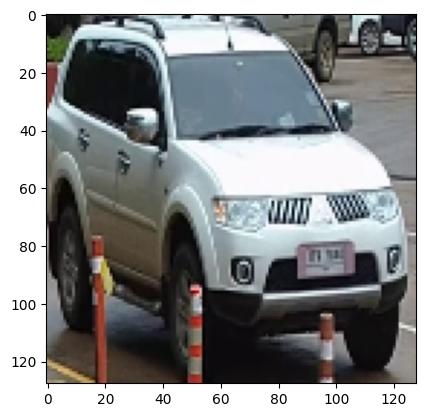

In [4]:
#observe loaded images by changing number in 'example'
example = 400
plt.imshow(img_data[example])
print(output_list[example])

### ImgDataGen

In [5]:
datagen = ImageDataGenerator(
    rotation_range=6,  # randomly rotate images in the range (degrees, 0 to 180)
    horizontal_flip=True, # flip horizontal of images
    featurewise_std_normalization = True, 
    shear_range=2,
)

image_generator = datagen.flow(img_data)

D:\anaconda3\envs\dl_env\lib\site-packages\keras\preprocessing\image.py:1462: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


D:\anaconda3\envs\dl_env\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
D:\anaconda3\envs\dl_env\lib\site-packages\keras\preprocessing\image.py:1873: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


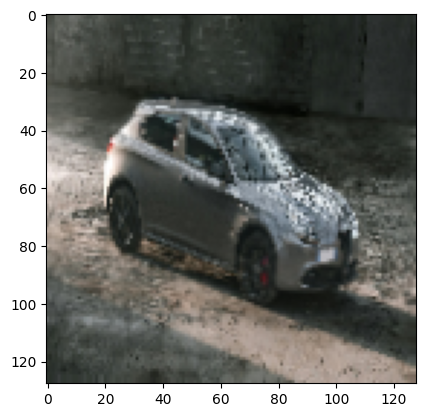

In [6]:
#preview image with datagen
plt.imshow(image_generator.next()[0])

---
### Labels List

In [7]:
#number oc classes
num_classes = 3

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

#set labels for each images
labels[0:592]=0
labels[593:1158]=1 
labels[1159:1690]=2

names = ['4wheels','6wheels','6wheels+']

def getLabel(id):
    return ['4wheels','6wheels','6wheels+'][id]

### Shuffle and Split dataset

In [8]:
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=4)
x_test=X_test

### Apply datagen to dataset

In [11]:
# Define separate training and validation data generators
train_generator = datagen.flow(X_train, y_train, batch_size=32) 
val_generator = datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

---
## Tranfer Learning pre-trained

In [9]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))  # Adjust input shape

# Freeze the base model layers (optional)
for layer in base_model.layers:
  layer.trainable = False

In [10]:
# Build your model on top
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)  # Optional dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x)  # Replace num_classes with the number of unique classes in your dataset

model = Model(inputs=base_model.input, outputs=predictions)

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

---
## Train model

In [12]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
result = model.fit(train_generator, epochs=5 ,validation_data=val_generator)

Epoch 1/5
37/37 [==============================] - 30s 717ms/step - loss: 1.5479 - accuracy: 0.4320 - val_loss: 0.9029 - val_accuracy: 0.5937
Epoch 2/5
37/37 [==============================] - 25s 672ms/step - loss: 0.8584 - accuracy: 0.6264 - val_loss: 0.7936 - val_accuracy: 0.6174
Epoch 3/5
37/37 [==============================] - 25s 676ms/step - loss: 0.7683 - accuracy: 0.6636 - val_loss: 0.7998 - val_accuracy: 0.6134
Epoch 4/5
37/37 [==============================] - 25s 688ms/step - loss: 0.7104 - accuracy: 0.6847 - val_loss: 0.6683 - val_accuracy: 0.7140
Epoch 5/5
37/37 [==============================] - 25s 682ms/step - loss: 0.6662 - accuracy: 0.6991 - val_loss: 0.6547 - val_accuracy: 0.7061


In [13]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

16/16 [==============================] - 7s 411ms/step - loss: 0.6200 - accuracy: 0.7258
Test accuracy: 0.7258382439613342


---
## Observe result

In [14]:
history = result.history

In [15]:
# Access individual metrics using their names
train_acc = history['accuracy']
val_acc = history['val_accuracy']
train_loss = history['loss']
val_loss = history['val_loss']

plt.figure(figsize=(10, 5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

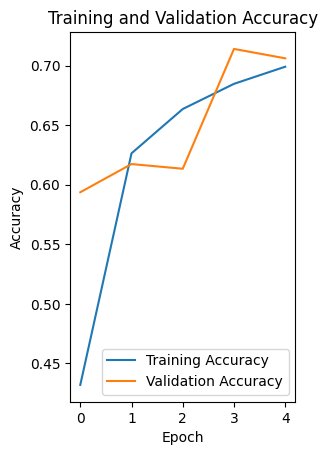

In [16]:
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

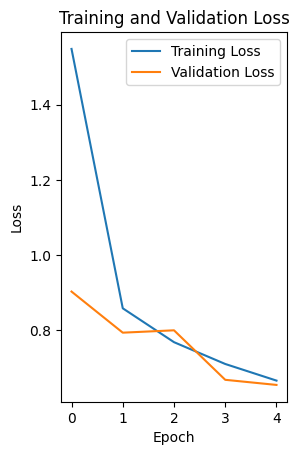

In [17]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

---
## Prediction

### load data & preprocess

In [18]:
test_path = "test"
test_dir_list = os.listdir(test_path)

img_test_list = []
output_test_list = []

for testset in test_dir_list:
    img_list = os.listdir(test_path + '/' + testset)
    print('Loaded the images of dataset-' + '{}\n'.format(testset))
    for img in img_list:
        input_img = cv2.imread(test_path + '/' + testset + '/' + img)
        input_img_resize = cv2.resize(input_img, (img_height,img_width))
        input_img_resize = cv2.cvtColor(input_img_resize, cv2.COLOR_BGR2RGB)
        img_test_list.append(input_img_resize)
        output_test_list.append(testset)

img_test = np.array(img_test_list)
img_test = img_test.astype('float32')
img_test = img_test/255
img_test.shape


Loaded the images of dataset-4wheels

Loaded the images of dataset-6wheels

Loaded the images of dataset-6wheels+



(30, 128, 128, 3)

In [19]:
num_of_samples = img_test.shape[0]
test_labels = np.ones((num_of_samples,),dtype='int64')

test_labels[0:9]=0
test_labels[10:19]=1
test_labels[20:]=2

names = ['4wheels','6wheels','6wheels+']

def getLabel(id):
    return ['4wheels','6wheels','6wheels+'][id]

4wheels


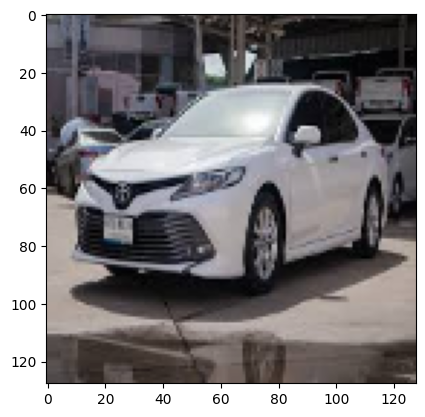

In [20]:
example = 8
plt.imshow(img_test[example])
print(output_test_list[example])

### Predict & Result

In [21]:
predict = model.predict(img_test, verbose=0)
predict = np.argmax(predict,axis=1)

In [22]:
print(len(predict))
print(predict)

30
[0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1]


In [23]:
def compare_and_count(list1, list2):
  same_count = 0
  for i in range(min(len(list1), len(list2))):
    if list1[i] == list2[i]:
      same_count += 1
  return len(list1), len(list2), same_count

# Example usage
list1 = predict
list2 = test_labels

total_elements1, total_elements2, same_count = compare_and_count(list1, list2)

print(f"List 1 has {total_elements1} elements.")
print(f"List 2 has {total_elements2} elements.")
print(f"{same_count} elements have the same value at the same index in both lists.")
total_accuracy = same_count/len(predict)
print(f"Accurcy: {total_accuracy}")

List 1 has 30 elements.
List 2 has 30 elements.
15 elements have the same value at the same index in both lists.
Accurcy: 0.5


---
# Load model & Test

In [24]:
# After training the model
model.save('trained_model.h5')  # Replace with your desired filename

In [25]:
from tensorflow.keras.models import load_model

loaded_model = load_model('trained_model.h5')

In [26]:
predict = model.predict(img_test, verbose=0)
predict = np.argmax(predict,axis=1)
print(len(predict))
print(predict)

30
[0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1]
